In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from pmdarima.preprocessing import FourierFeaturizer

from catboost import CatBoostRegressor
import shap as sp


from sklearn.metrics import mean_absolute_percentage_error

In [2]:
pd.options.display.max_columns = None

In [3]:
df = pd.read_csv('daily-website-visitors.csv')[["Date", "Page.Loads"]].rename(columns={"Date": 'ds', "Page.Loads": 'y'})

In [4]:
df['ds'] = pd.to_datetime(df.ds, yearfirst = True)

df['y'] = df.y.str.replace(',','.').astype("float")

In [5]:
df_train = df[['ds', 'y']].iloc[:-365]
df_test = df[['ds', 'y']].iloc[-365:]

In [6]:
period = 365.25
N_fourier = 10
lags = 14

In [7]:
#Preprocessing
y = df_train.set_index('ds')

forecast_index = pd.DataFrame(pd.date_range(start=y.index.max() + pd.Timedelta(days=1), periods=365, freq='D'), columns=['ds']).set_index('ds')

y = pd.concat([y, forecast_index])

y, X = FourierFeaturizer(period, N_fourier).fit_transform(y)

for i in range(1, lags): y['y_'+str(i)] = y['y'].shift(i)
    
X = pd.concat([y, X.set_index(y.index)], axis=1)

X["DayOfWeek"] = X.index.dayofweek.astype('str')

In [8]:
X_train, y_train, X_test, y_test = X.iloc[:-365].drop('y', axis=1), X.iloc[:-365].y, X.iloc[-365:].drop('y', axis=1), df_test.set_index('ds')

In [9]:
reg_catboost = CatBoostRegressor(has_time=True, cat_features=['DayOfWeek'],
                                iterations= 300, learning_rate= 0.1, depth= 4, l2_leaf_reg= 0.8, bagging_temperature= 3)
reg_catboost.fit(X_train, y_train, verbose = False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [10]:
#Forecast
y_hat = pd.DataFrame(index=X_test.index, columns=['yhat'])

lag_indices = [f'y_{j}' for j in range(1, lags)]

for i in range(len(X_test)):
    y_hat_i = reg_catboost.predict(X_test.iloc[i])
    
    if(i < len(X_test)-1):
        X_test.loc[X_test.index[i+1], 'y_1'] = y_hat_i
        X_test.loc[X_test.index[i+1], lag_indices[1:]] = X_test.loc[X_test.index[i], lag_indices[:-1]].values

    y_hat.iloc[i] = y_hat_i

In [11]:
print(mean_absolute_percentage_error(y_train, reg_catboost.predict(X_train)))
print(mean_absolute_percentage_error(y_test, y_hat))

0.04008838047985904
0.11279243350378115


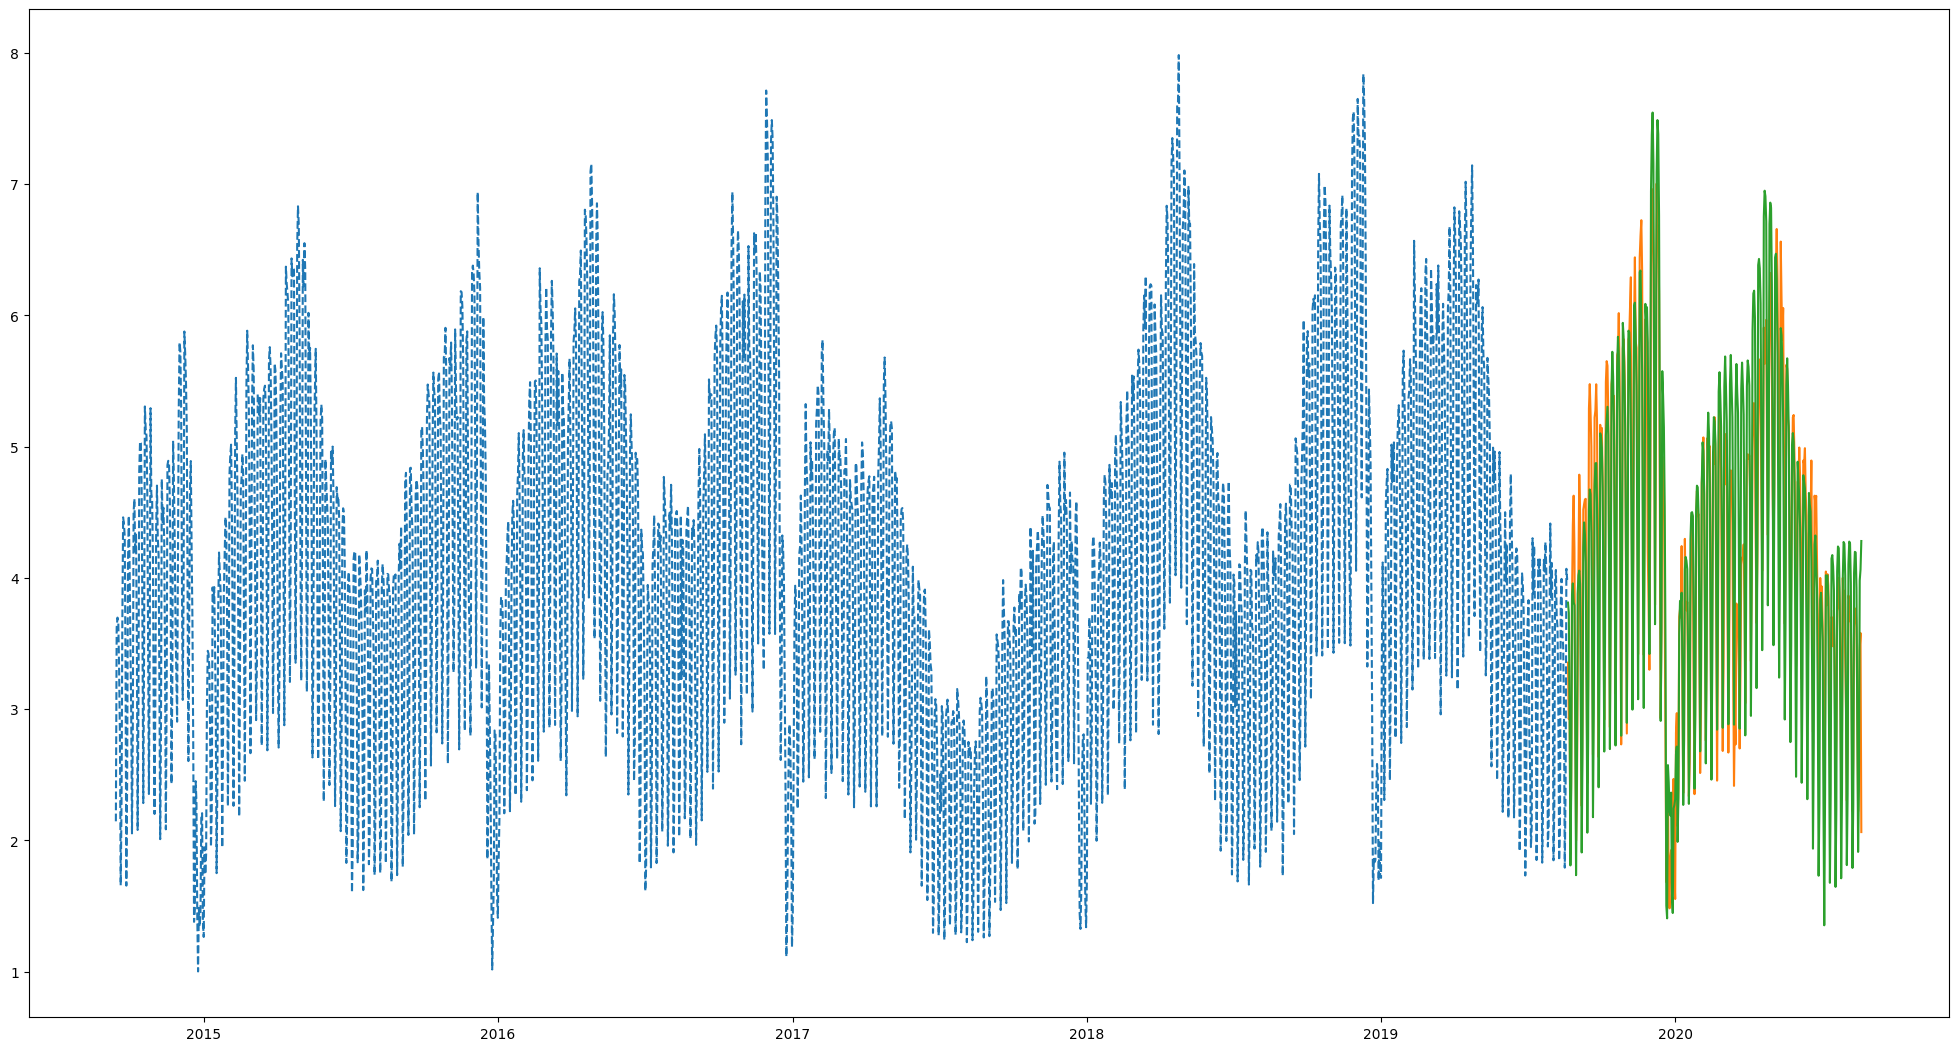

In [12]:
plt.plot(df_train.ds, df_train.y, '--')
#plt.plot(df.ds, reg_catboost.predict(X_train))
plt.plot(df_test.ds, df_test.y)
plt.plot(y_hat.index, y_hat.yhat)
plt.subplots_adjust(left=-1, bottom=-2, right=2, top=0.1, wspace=0.25, hspace=0.5)

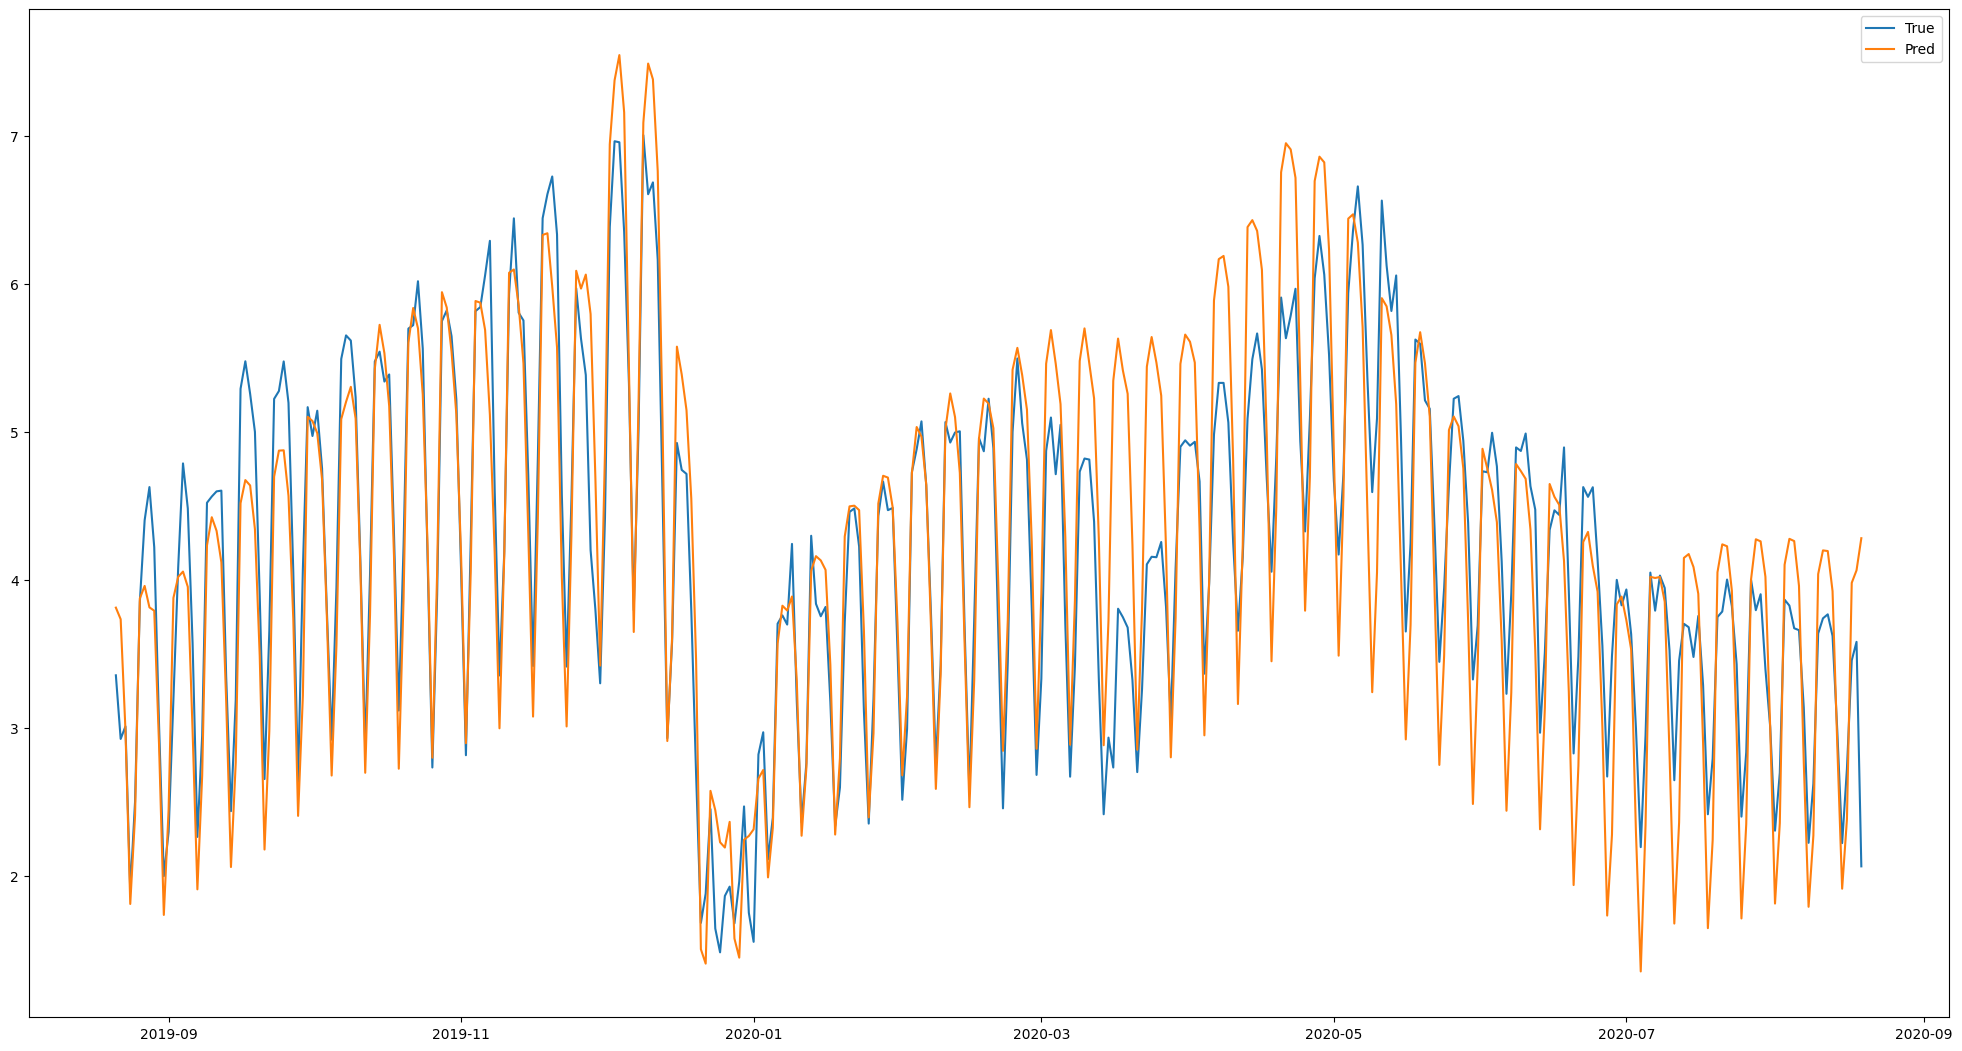

In [13]:
plt.plot(df_test.ds, df_test.y, label="True")
plt.plot(y_hat.index, y_hat.yhat, label="Pred")
plt.legend()
plt.subplots_adjust(left=-1, bottom=-2, right=2, top=0.1, wspace=0.25, hspace=0.5)

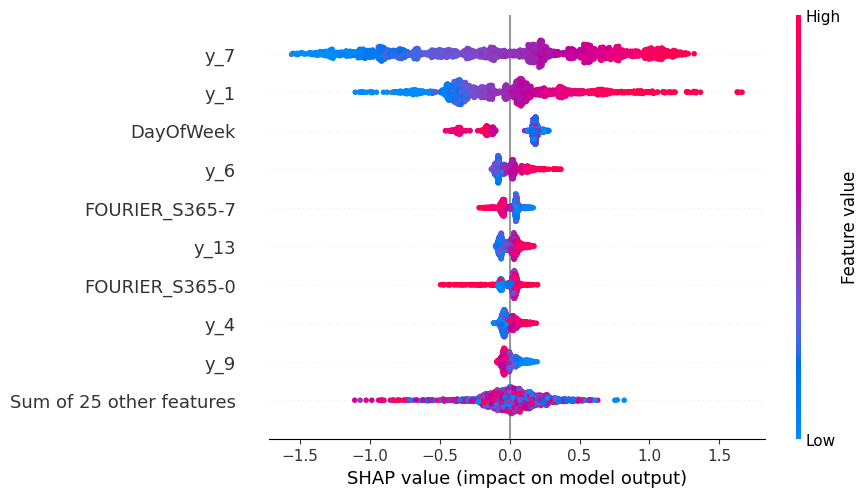

In [14]:
explainer = sp.TreeExplainer(reg_catboost)
sp.plots.beeswarm(explainer(X_train))